### Distribution map of COVID-19 cases in Ceará

The final map is intended to be submitted to wikidata item [Q90267612](https://www.wikidata.org/wiki/Q90267612).

The [original notebook](https://github.com/lubianat/covid_19_sandbox/blob/master/sao_paulo_covid/Map%20of%20Covid-19%20Cases%20in%20S%C3%A3o%20Paulo.ipynb) was made by Tiago Lubiana for São Paulo state, this is merely an adaption, so thank him!

In [1]:
import pandas as pd
from datetime import date,datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import requests

Thanks a lot to [André Campos](https://github.com/andreloc) for his workshop in Open Data Day - Fortaleza teaching how to use the Integrasus API, which I attended. The following code snippet is his creation.

In [2]:
def get_dataframe(api_url, id_municipio=''):    
    api_url = api_url + '?'
    if(id_municipio != ''): 
        api_url = '{}idMunicipio={}&'.format(api_url, id_municipio)
    
    result = requests.get(api_url)
    result = result.json()    
    result = pd.DataFrame.from_dict(result)
    
    if(id_municipio != ''): 
        result.insert(0, 'idMunicipio', id_municipio)
        
    return result

In [3]:
api_endpoint = "https://indicadores.integrasus.saude.ce.gov.br/api/coronavirus/qtd-por-dia-tipo"
qtd_por_municipios  = get_dataframe('https://indicadores.integrasus.saude.ce.gov.br/api/coronavirus/qtd-por-municipio')

In [4]:
qtd_por_municipios = qtd_por_municipios.query("tipo == 'Confirmado'")
qtd_por_municipios

tipo  quantidade  idMunicipio        municipio
0    Confirmado           1     230010.0          ABAIARA
1    Confirmado           9     230015.0          ACARAPE
2    Confirmado         120     230020.0           ACARAU
3    Confirmado           8     230030.0         ACOPIARA
4    Confirmado           1     230040.0           AIUABA
..          ...         ...          ...              ...
166  Confirmado           4     231390.0           URUOCA
167  Confirmado           7     231395.0          VARJOTA
168  Confirmado           8     231400.0    VARZEA ALEGRE
169  Confirmado          34     231410.0  VICOSA DO CEARA
170  Confirmado         135          NaN   SEM INFORMAÇÃO

[171 rows x 4 columns]

In [5]:
np.sum(qtd_por_municipios['quantidade'])

16064

In [6]:
mapa_dos_municipios = gpd.read_file("../shapefiles/23MUE250GC_SIR.shp")

In [7]:
mapa_dos_municipios.columns = ['municipio', 'idMunicipio', 'geometry']
mapa_dos_municipios.head()

municipio idMunicipio                                           geometry
0   ABAIARA     2300101  POLYGON ((-38.97030 -7.42638, -38.97030 -7.426...
1   ACARAPE     2300150  POLYGON ((-38.61977 -4.16438, -38.61985 -4.169...
2    ACARAÚ     2300200  POLYGON ((-39.94349 -2.86047, -39.94722 -2.870...
3  ACOPIARA     2300309  POLYGON ((-39.05229 -6.02587, -39.05247 -6.038...
4    AIUABA     2300408  POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...

In [8]:
ce_conf = qtd_por_municipios.loc[:,['municipio', 'quantidade']]

In [9]:
mapa_dos_municipios['municipio'] = mapa_dos_municipios['municipio']
map_conf = pd.merge(mapa_dos_municipios, ce_conf, on='municipio', how='left')
map_conf

municipio idMunicipio  \
0            ABAIARA     2300101   
1            ACARAPE     2300150   
2             ACARAÚ     2300200   
3           ACOPIARA     2300309   
4             AIUABA     2300408   
..               ...         ...   
179      URUBURETAMA     2313807   
180           URUOCA     2313906   
181          VARJOTA     2313955   
182    VÁRZEA ALEGRE     2314003   
183  VIÇOSA DO CEARÁ     2314102   

                                              geometry  quantidade  
0    POLYGON ((-38.97030 -7.42638, -38.97030 -7.426...         1.0  
1    POLYGON ((-38.61977 -4.16438, -38.61985 -4.169...         9.0  
2    POLYGON ((-39.94349 -2.86047, -39.94722 -2.870...         NaN  
3    POLYGON ((-39.05229 -6.02587, -39.05247 -6.038...         8.0  
4    POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...         1.0  
..                                                 ...         ...  
179  POLYGON ((-39.45588 -3.64239, -39.45588 -3.642...        19.0  
180  POLYGON ((-40.69245 -3.24248, -40.66954 -3.247...         4.0  
181  POLYGON ((-40.43172 -4.09169, -40.43229 -4.093...         7.0  
182  POLYGON ((-39.10939 -6.71454, -39.10954 -6.715...         NaN  
183  POLYGON ((-40.88885 -3.52244, -40.87687 -3.532...         NaN  

[184 rows x 4 columns]

In [10]:
map_conf["quantidade"] = map_conf["quantidade"].fillna(0)
natural_order=["0", "1-10", "11-50", "51-500",">500", ">1000", ">10000"]
map_conf["casos_categorizados"] = pd.cut(map_conf["quantidade"],
                                                    bins = [-1,1, 10,50,500,1000, 10000,100000000],
                                                   labels = natural_order)


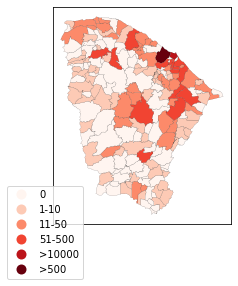

In [11]:
fig, ax = plt.subplots()
ax = map_conf.plot(column='casos_categorizados',
                         categorical=True, 
                         legend=True, 
                         figsize=(100,6),
                         markersize=46,
                         cmap = "Reds",
                         edgecolor='k',
                         linewidth=0.1,
                         ax=ax);
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
# plt.savefig("figs/casos_ce_" + "16_april" + ".png", dpi = 300)

### Altair alternatives

In [12]:
import altair as alt

Static version

In [13]:
alt.Chart(map_conf).mark_geoshape(
    stroke="lightgray",
    strokeOpacity=0.2
).encode(
    alt.Color('casos_categorizados:O',sort=natural_order,scale=alt.Scale(scheme='lightorange'))
).properties(
    width=450,
    height=300
).configure_legend(
    title=None
).configure_view(
    strokeWidth=0
)

alt.Chart(...)

Adding interactivity: Selection by group on click + tooltip
(Try clicking and hovering)

In [14]:
selection = alt.selection_multi(fields=['casos_categorizados'])

color = alt.condition(selection,
              alt.Color('casos_categorizados:O',
              sort=natural_order,
              scale=alt.Scale(scheme='lightorange')),
              alt.value('lightgray'))

alt.Chart(map_conf).mark_geoshape(
    stroke='lightgray',
    strokeOpacity=0.2
).encode(
    color=color,
    tooltip=[alt.Tooltip('municipio:N', title="City"), 
             alt.Tooltip('quantidade:Q', title="Confirmed cases")]
).properties(
    width=450,
    height=300
).configure_legend(
    title=None
).add_selection(
        selection
).configure_view(
    strokeWidth=0
)

alt.Chart(...)